In [1]:
import sys
sys.path.append('../..')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os 

from helpers.utils import (
    BAD_RP_VALUES,
    GOOD_RP_VALUES,
    count_url_components,
    count_uniq_dom_RP,
    calculate_rank_statistics
)

In [2]:
# file_path = '../../output/data_raw/2025-02-08_noAct_raw.parquet'
file_path = '../../output/data_raw/2024-01-24_SF_raw.parquet'
# file_path = '../../output/data_raw/2024-01-24_AMS_raw.parquet'

df = pd.read_parquet(file_path)

In [3]:
import re
match = re.search(r'(\d{4}-\d{2}-\d{2})_([^_]+)', file_path)
if match:
    extract_date, extract_type = match.groups()
    print("Date:", extract_date)
    print("Type:", extract_type)



Date: 2024-01-24
Type: SF


In [4]:
intersection_file = '../../helpers/intersection'

with open(intersection_file, "r") as file:
    intersection = file.read().splitlines()

In [5]:
# cleaning
df = df[df.failed_visit == False]
df = df[df.init_url.isin(intersection)]
df = df[df.final_url != "about:blank"]

# General

In [6]:
df.final_host.nunique()

27414

In [7]:
path_count, path_query_count, path_or_query = count_url_components(df)

In [8]:
print("Total unique domains with path >= 10 chars:", path_count)
print("Total unique domains with path and query >= 10 chars:", path_query_count)
print("Total unique domains with path or query >= 10 chars:", path_or_query)

Total unique domains with path >= 10 chars: 27414
Total unique domains with path and query >= 10 chars: 3534
Total unique domains with path or query >= 10 chars: 27414


In [10]:
count_uniq_dom_RP(df)

no-referrer : 2622
same-origin : 638
origin : 2216
strict-origin : 175
strict-origin-when-cross-origin : 27414
origin-when-cross-origin : 1484
no-referrer-when-downgrade : 2604
unsafe-url : 1442


In [11]:
# Group by website_domain and count unique ref_pol values
ref_pol_counts = df.groupby('final_host')['ref_pol'].nunique()

# Calculate the average number of ref_pol per website_domain
average_ref_pol_per_domain = ref_pol_counts.mean()

print(f'Average number of ref_pol per website_domain: {average_ref_pol_per_domain}')
# Find the maximum number of unique ref_pol values per website_domain
max_ref_pol_per_domain = ref_pol_counts.max()

print(f'Maximum number of ref_pol per website_domain: {max_ref_pol_per_domain}')
# Find the website_domain with the maximum number of unique ref_pol values
max_ref_pol_domain = ref_pol_counts.idxmax()

print(f'Website domain with the maximum number of unique ref_pol values: {max_ref_pol_domain}')

# Calculate the median number of ref_pol per website_domain
median_ref_pol_per_domain = ref_pol_counts.median()

print(f'Median number of ref_pol per website_domain: {median_ref_pol_per_domain}')


Average number of ref_pol per website_domain: 1.4078572991901948
Maximum number of ref_pol per website_domain: 6
Website domain with the maximum number of unique ref_pol values: breezeline.com
Median number of ref_pol per website_domain: 1.0


In [12]:
# Filter the ref_pol_counts to get website_domains with ref_pol > 1
domains_with_multiple_ref_pol = ref_pol_counts[ref_pol_counts > 1]

# Get the count of such website_domains
num_domains_with_multiple_ref_pol = domains_with_multiple_ref_pol.count()

print(f'Number of website_domains with ref_pol > 1: {num_domains_with_multiple_ref_pol}')

print(f'Percentage of website_domains with ref_pol > 1: {num_domains_with_multiple_ref_pol/df.final_host.nunique()*100:.2f}%')



Number of website_domains with ref_pol > 1: 8798
Percentage of website_domains with ref_pol > 1: 32.09%


# Permissive vs Restrictive


In [13]:
categories_df = pd.read_csv('../../helpers/categories.csv')
categories_df = categories_df[['init_host', 'Categories']]

In [14]:
df = df.merge(categories_df, left_on='final_host', right_on='init_host', how='left')

## Permissive


In [15]:
# Filter the dataframe for rows where ref_pol is in BAD_RP_VALUES
bad_rp_df = df[df.ref_pol.isin(BAD_RP_VALUES)]

# Drop duplicates based on website_domain
bad_rp_unique_df = bad_rp_df.drop_duplicates(subset='final_host')

bad_rp_categories_df = bad_rp_unique_df.Categories.value_counts().reset_index()
bad_rp_categories_df.columns = ['Category', 'Count']

## Restictive

In [16]:
# Filter the dataframe for rows where ref_pol is in GOOD_RP_VALUES
good_rp_df = df[df.ref_pol.isin(GOOD_RP_VALUES)]

# Drop duplicates based on website_domain
good_rp_unique_df = good_rp_df.drop_duplicates(subset='final_host')

good_rp_categories_df = good_rp_unique_df.Categories.value_counts().reset_index()
good_rp_categories_df.columns = ['Category', 'Count']

## Count Members


In [17]:
bad_rp_categories_df['type'] = 'bad'
good_rp_categories_df['type'] = 'good'

In [18]:
mix_rp_unique_df = pd.concat([bad_rp_categories_df, good_rp_categories_df])


mix_rp_unique_df['Category'] = mix_rp_unique_df['Category'].str.replace('- ', '', regex=False)
mix_rp_unique_df['Category'] = mix_rp_unique_df['Category'].str.replace('-', ' ', regex=False)

mix_rp_unique_df

,Category,Count,type
0,Business,720,bad
1,Blogs/Wikis,520,bad
2,Shopping/Merchandizing,472,bad
3,Marketing/Merchandising,320,bad
4,Education/Reference,284,bad
...,...,...,...
77,Resource Sharing,1,good
78,Profanity,1,good
79,Controversial Opinions,1,good
80,Game/Cartoon Violence,1,good


In [19]:
cat_count = pd.read_csv('../../helpers/categories_count.csv')

In [20]:
mix_rp_unique_df = mix_rp_unique_df.merge(cat_count, left_on='Category', right_on='Categories', how='left')
mix_rp_unique_df['percentage'] = (mix_rp_unique_df['Count'] / mix_rp_unique_df['cat_count']) * 100
filtered_df = mix_rp_unique_df[mix_rp_unique_df.cat_count > 100]

In [21]:
mix_rp_unique_df

,Category,Count,type,Categories,cat_count,Take?,percentage
0,Business,720,bad,Business,3992,True,18.036072
1,Blogs/Wikis,520,bad,Blogs/Wikis,1701,True,30.570253
2,Shopping/Merchandizing,472,bad,Shopping/Merchandizing,3445,True,13.701016
3,Marketing/Merchandising,320,bad,Marketing/Merchandising,2267,True,14.115571
4,Education/Reference,284,bad,Education/Reference,1855,True,15.309973
...,...,...,...,...,...,...,...
159,Resource Sharing,1,good,Resource Sharing,3,True,33.333333
160,Profanity,1,good,Profanity,10,True,10.000000
161,Controversial Opinions,1,good,Controversial Opinions,2,True,50.000000
162,Game/Cartoon Violence,1,good,Game/Cartoon Violence,2,True,50.000000


In [22]:
os.makedirs("../../output/chart", exist_ok=True)

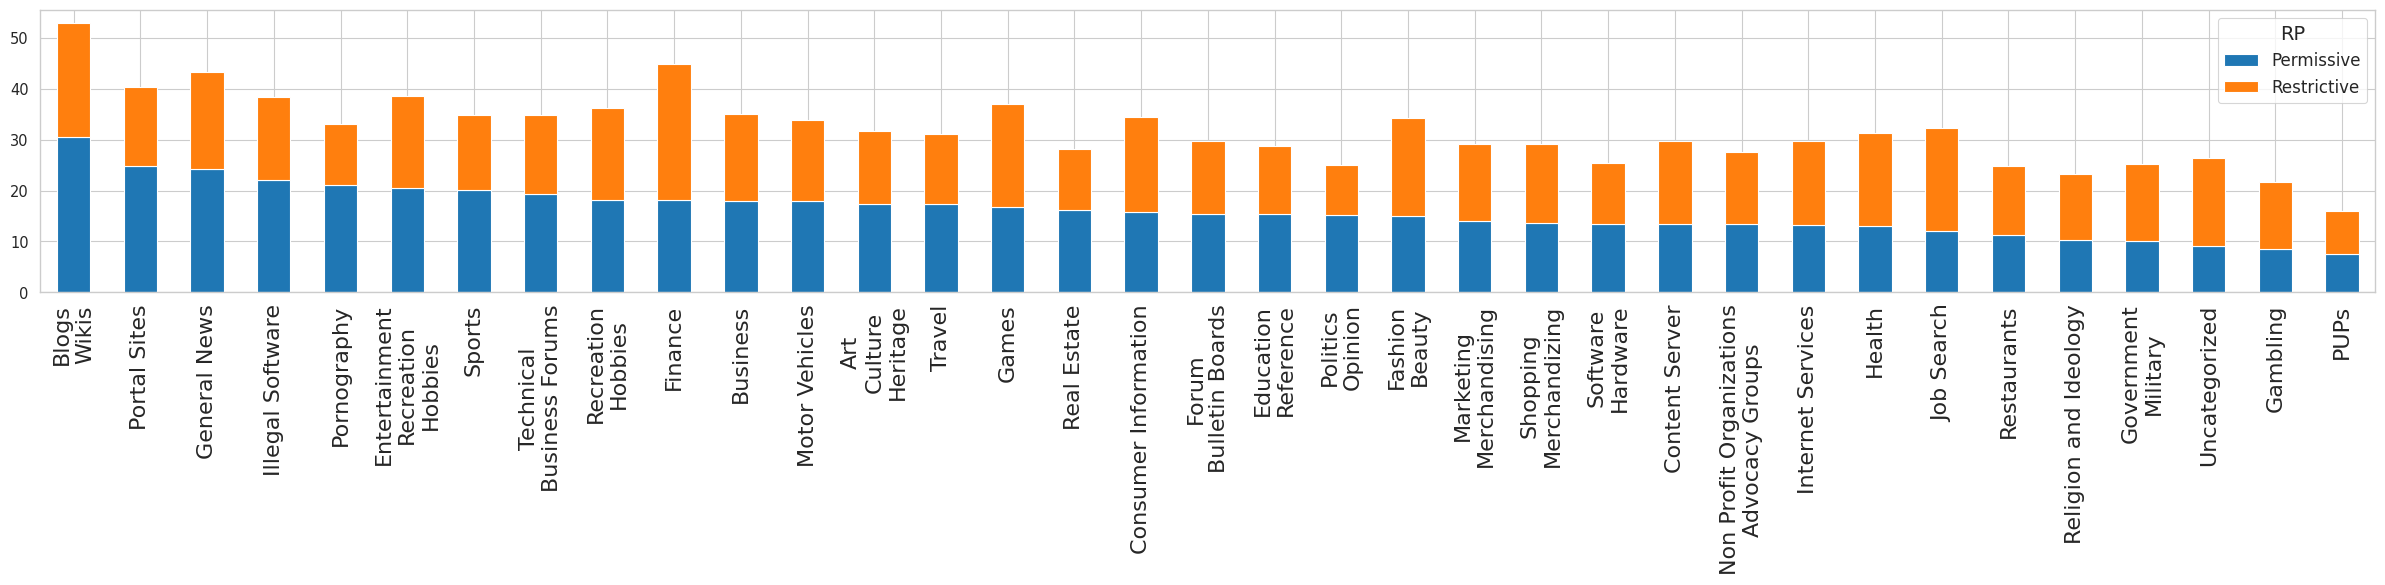

In [23]:
# Set the visual style and context with an increased font scale for better readability
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.2)

# Create a pivot table for the stacked bar chart
pivot_df = filtered_df.pivot(index='Category', columns='type', values='percentage').fillna(0)
pivot_df = pivot_df.sort_values(by='bad', ascending=False)

# Create the figure and axis objects for greater control
fig, ax = plt.subplots(figsize=(24, 6))


# Plot the stacked bar chart using the defined colors
pivot_df.plot(kind='bar', stacked=True, ax=ax, 
            #   color=colors
              )

# Improve x-axis tick labels: split labels on '/' and increase font size
new_labels = ['\n'.join(label.split('/')) for label in pivot_df.index]
ax.set_xticklabels(new_labels, fontsize=16, rotation=90)

# Set axis labels and title for better clarity
ax.set_xlabel("")

# Update the legend: set a title, custom labels, and adjust font sizes
legend_labels = ['Permissive', 'Restrictive']
legend = ax.legend(title="RP", labels=legend_labels, loc='upper right', fontsize=12)
legend.get_title().set_fontsize(14)

plt.tight_layout()

plt.savefig("../../output/chart/"+extract_type+"_goodvsbad.png", dpi=300, bbox_inches="tight")


# Show the plot
plt.show()

## Ranking 

In [24]:
tranco_df = pd.read_csv('../../helpers/tranco_7PL6X.csv')

rank = df.merge(tranco_df, left_on='final_host', right_on='domain')

In [25]:
calculate_rank_statistics(rank)

Max value of rank_of_sites: 1000000
Min value of rank_of_sites: 1
Median value of rank_of_sites: 464313.0


In [26]:
rank_bad = rank[rank.ref_pol.isin(BAD_RP_VALUES)].drop_duplicates(['final_host'])[['final_host', 'rank_of_sites']]
rank_bad['RP_Values'] = 'BAD_RP'
rank_bad

,final_host,rank_of_sites,RP_Values
419,acom.us,676886,BAD_RP
601,cerebra.org.uk,561861,BAD_RP
1412,churchsource.com,164683,BAD_RP
1807,souffle.life,406057,BAD_RP
4476,ashly.com,707578,BAD_RP
...,...,...,...
13526717,nosartisansontdutalent.fr,742506,BAD_RP
13535635,taptap.in,972588,BAD_RP
13538157,projectgo.pro,545529,BAD_RP
13581299,xbooks.work,990631,BAD_RP


In [27]:
calculate_rank_statistics(rank_bad)

Max value of rank_of_sites: 999994
Min value of rank_of_sites: 1
Median value of rank_of_sites: 417219.5


In [28]:
rank_good = rank[rank.ref_pol.isin(GOOD_RP_VALUES)].drop_duplicates(['final_host'])[['final_host', 'rank_of_sites']]
rank_good['RP_Values'] = 'GOOD_RP'
rank_good

,final_host,rank_of_sites,RP_Values
2478,seatunique.com,191298,GOOD_RP
2637,amerisourcebergen.com,25275,GOOD_RP
4026,forumginekologii.pl,888359,GOOD_RP
4904,volleybolist.ru,608756,GOOD_RP
5138,1800tequila.com,530388,GOOD_RP
...,...,...,...
13575539,dior.ae,339793,GOOD_RP
13582388,wm.edu,9943,GOOD_RP
13585338,herogames.com,560739,GOOD_RP
13589784,cphi-online.com,211051,GOOD_RP


In [29]:
calculate_rank_statistics(rank_good)

Max value of rank_of_sites: 999997
Min value of rank_of_sites: 1
Median value of rank_of_sites: 422384.0
